In [1]:
!pip install --upgrade kagglehub

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

from tensorflow import data, keras
from tensorflow.keras import Sequential, optimizers, layers, regularizers, models, callbacks

import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

from os.path import join

## Загрузка данных и их основные характеристики

In [5]:
path = kagglehub.dataset_download('laotse/credit-risk-dataset')
path

'C:\\Users\\rayshite\\.cache\\kagglehub\\datasets\\laotse\\credit-risk-dataset\\versions\\1'

In [7]:
df = pd.read_csv(join(path, 'credit_risk_dataset.csv'))

df.head().T

,0,1,2,3,4
person_age,22,21,25,23,24
person_income,59000,9600,9600,65500,54400
person_home_ownership,RENT,OWN,MORTGAGE,RENT,RENT
person_emp_length,123.0,5.0,1.0,4.0,8.0
loan_intent,PERSONAL,EDUCATION,MEDICAL,MEDICAL,MEDICAL
loan_grade,D,B,C,C,C
loan_amnt,35000,1000,5500,35000,35000
loan_int_rate,16.02,11.14,12.87,15.23,14.27
loan_status,1,0,1,1,1
loan_percent_income,0.59,0.1,0.57,0.53,0.55


In [9]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [11]:
len(df)

32581

In [13]:
df.describe(include='all').round()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,32581.0,32581.0,32581,31686.0,32581,32581,32581.0,29465.0,32581.0,32581.0,32581,32581.0
unique,NaN,NaN,4,NaN,6,7,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,RENT,NaN,EDUCATION,A,NaN,NaN,NaN,NaN,N,NaN
freq,NaN,NaN,16446,NaN,6453,10777,NaN,NaN,NaN,NaN,26836,NaN
mean,28.0,66075.0,NaN,5.0,NaN,NaN,9589.0,11.0,0.0,0.0,NaN,6.0
std,6.0,61983.0,NaN,4.0,NaN,NaN,6322.0,3.0,0.0,0.0,NaN,4.0
min,20.0,4000.0,NaN,0.0,NaN,NaN,500.0,5.0,0.0,0.0,NaN,2.0
25%,23.0,38500.0,NaN,2.0,NaN,NaN,5000.0,8.0,0.0,0.0,NaN,3.0
50%,26.0,55000.0,NaN,4.0,NaN,NaN,8000.0,11.0,0.0,0.0,NaN,4.0
75%,30.0,79200.0,NaN,7.0,NaN,NaN,12200.0,13.0,0.0,0.0,NaN,8.0


## Поиск и удаление дубликатов

In [15]:
df[df.duplicated()] # Смотрим есть ли дубликаты

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [17]:
df = df.drop_duplicates() # Удаляем дубликаты
df.shape

(32416, 12)

## Устранение пропусков в данных

In [19]:
df.isnull().sum() # Смотрим, есть ли пропуски в данных

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

<Axes: >

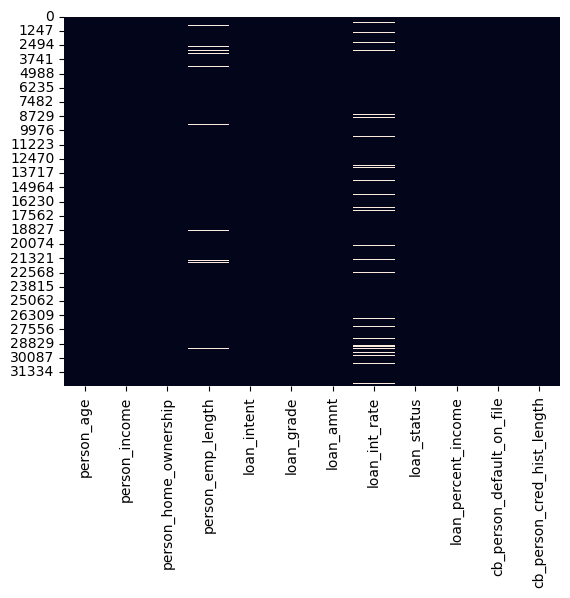

In [21]:
sns.heatmap(df.isnull(), cbar=False) # Визуализируем пропущенные значения

In [23]:
# Заполняем пропуски методом k ближайших соседей
df_num = df.select_dtypes(np.number) # Создаем новый датафрейм, содержащий только числовые признаки
imputer = KNNImputer(n_neighbors=5, weights='uniform')
imputer.fit(df_num)
df_num = pd.DataFrame(imputer.transform(df_num), index=df_num.index, columns=df_num.columns)

# Перезаписываем столбцы содержащие пропуски
df.loc[:, 'person_emp_length'] = df_num['person_emp_length']
df.loc[:, 'loan_int_rate'] = df_num['loan_int_rate']

df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

## Поиск и обработка аномалий

In [25]:
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns + '_n')

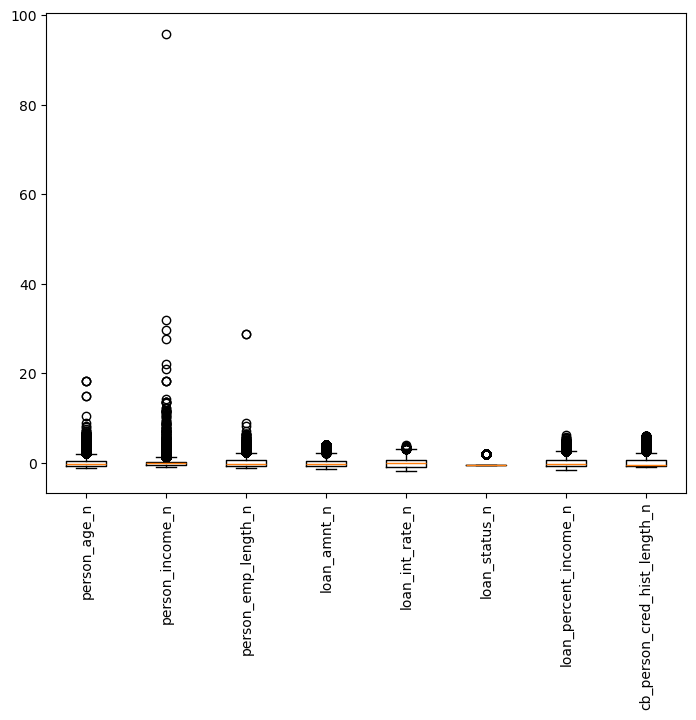

In [27]:
# Смотрим есть ли выбросы

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot(df_std.values, widths=0.5)

ax.set_xticks(range(1, len(df_std.columns) + 1)) 
ax.set_xticklabels(df_std.columns, rotation=90)  

plt.show()

In [29]:
# Обнаружение выбрасов меетодом кластерного анализа
clustering = DBSCAN(eps=4, min_samples=3).fit(df_std)
df['labels'] = clustering.labels_

df_numeric = df.select_dtypes(include=['number'])
df_numeric[df['labels'] == -1]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,labels
0,22,59000,123.0,35000,16.020,1,0.59,3,-1
81,144,250000,4.0,4800,13.570,0,0.02,3,-1
183,144,200000,4.0,6000,11.860,0,0.03,2,-1
210,21,192000,123.0,20000,6.540,0,0.10,4,-1
575,123,80004,2.0,20400,10.250,0,0.25,3,-1
747,123,78000,7.0,20000,13.294,0,0.26,4,-1
30049,42,2039784,0.0,8450,12.290,0,0.00,15,-1
32297,144,6000000,12.0,5000,12.730,0,0.00,25,-1
32300,51,667680,19.0,10000,13.980,0,0.01,22,-1
32355,78,48000,41.0,3000,7.510,0,0.06,25,-1


In [31]:
# Удаление строк, содержащих аномалии
df.drop(df[df.labels == -1].index, inplace=True)
df.drop('labels', axis=1, inplace=True)
df.shape

(32404, 12)

## Кодирование категориальных признаков

In [33]:
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'N': 0, 'Y': 1}) 

df['loan_grade'] = df['loan_grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}) 

categorical_columns = ['person_home_ownership', 'loan_intent']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=df.index)
df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)
df_encoded.columns = df_encoded.columns.str.lower()
df = df_encoded

df.shape

(32404, 20)

## Разделение исходного набора данных на обучающую и тестовую выборки

In [35]:
y = df['loan_status']
X = df.drop('loan_status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

val_ratio = 0.2 / 0.8
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, random_state=0, stratify=y_train)

In [37]:
# Стандартизация числовых признаков
num_cols = ['person_age','person_income','person_emp_length',
             'loan_amnt','loan_int_rate','loan_percent_income',
             'cb_person_cred_hist_length']

scaler = StandardScaler().fit(X_train[num_cols])

X_train = X_train.copy()
X_test = X_test.copy()
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

In [39]:
print(X_train.shape, X_val.shape, X_test.shape)

(19442, 19) (6481, 19) (6481, 19)


In [47]:
BATCH = 256

train_ds = (data.Dataset
            .from_tensor_slices((X_train, y_train))
            .shuffle(len(X_train))
            .batch(BATCH)
            .prefetch(data.AUTOTUNE))

val_ds = (data.Dataset
          .from_tensor_slices((X_val, y_val))
          .batch(BATCH)
          .prefetch(data.AUTOTUNE))

test_ds = (data.Dataset
          .from_tensor_slices((X_test, y_test))
          .batch(BATCH))

In [49]:
# Вычисляем веса классов
y_array = y_train.values 

weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array([0, 1]), 
            y=y_array)

class_weight = {0: weights[0], 1: weights[1]}
class_weight

{0: 0.639960500329164, 1: 2.2862182502351835}

## Вспомогательные методы

In [51]:
def visualize(history):

    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    acc = history_dict["accuracy"]
    val_acc  = history_dict["val_accuracy"]
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(12, 5))           

    plt.subplot(1, 2, 1)                 
    plt.plot(epochs, loss_values, "b", label="Потери на этапе обучения")
    plt.plot(epochs, val_loss_values, "c", label="Потери на этапе проверки")
    plt.title("Потери на этапах обучения и проверки")
    plt.xlabel("Эпохи")
    plt.ylabel("Потери")
    plt.legend()

    plt.subplot(1, 2, 2)                  
    plt.plot(epochs, acc, "b", label="Точность на этапе обучения")
    plt.plot(epochs, val_acc, "c", label="Точность на этапе проверки")
    plt.title("Точность на этапах обучения и проверки")
    plt.xlabel("Эпохи")
    plt.ylabel("Точность")
    plt.legend()

    plt.tight_layout()                    
    plt.show()

In [53]:
def fit_model(model, checkpoint_path):
    metrics = [
        keras.metrics.AUC(name="roc_auc", curve="ROC"),  
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision"),     
        keras.metrics.Recall(name="recall"),
    ]
         
    model.compile(optimizer=optimizers.Adam(learning_rate=0.002), loss='binary_crossentropy', metrics=metrics) 

    callbacks = [  
        keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True, )
    ]

    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=1024,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=0,
        class_weight=class_weight
    )

    visualize(history)

In [55]:
def evaluate_model(checkpoint_path):
    model = keras.models.load_model(checkpoint_path)
    results = model.evaluate(test_ds, return_dict=True)
    return results

## Обучение базовой модели

In [59]:
base_model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation="relu", name="layer_1"),
    layers.Dense(256, activation="relu", name="layer_2"),
    layers.Dense(128, activation="relu", name="layer_3"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
])

In [61]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_1 (Dense)                 │ (None, 512)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,593 (682.00 KB)

 Trainable params: 174,593 (682.00 KB)

 Non-trainable params: 0 (0.00 B)

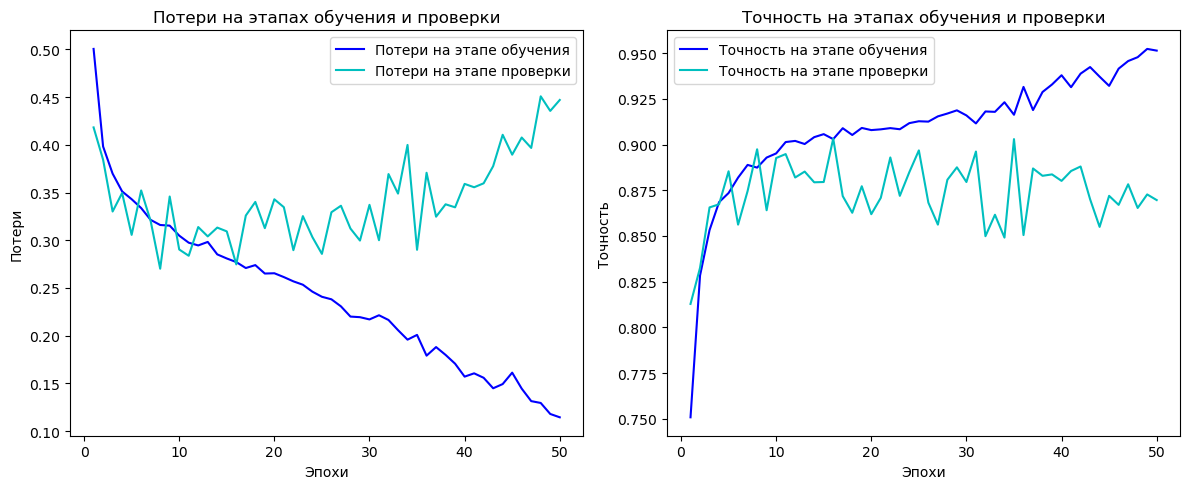

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8947 - loss: 0.2830 - precision: 0.7823 - recall: 0.7270 - roc_auc: 0.9106   


{'accuracy': 0.8997068405151367,
 'loss': 0.27232739329338074,
 'precision': 0.7831858396530151,
 'recall': 0.7489421963691711,
 'roc_auc': 0.9195204377174377}

In [63]:
fit_model(base_model, "base_model.keras")
evaluate_model("base_model.keras")

## Повышение обобщающей способности модели

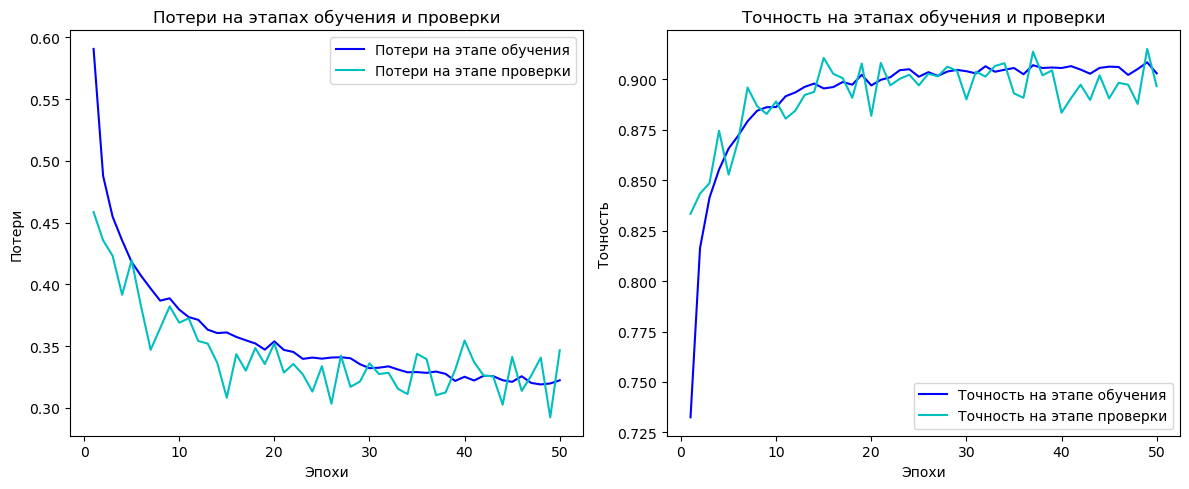

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.2987 - precision: 0.8560 - recall: 0.7165 - roc_auc: 0.9148   


{'accuracy': 0.9140564799308777,
 'loss': 0.2916874587535858,
 'precision': 0.8572614192962646,
 'recall': 0.7284908294677734,
 'roc_auc': 0.9207542538642883}

In [65]:
improved_model = keras.Sequential([
    layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dense(1, activation="sigmoid")
])

fit_model(improved_model, "improved_model.keras")
evaluate_model("improved_model.keras")